Click to run on kaggle (if you're not already there): [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/datasets/medali1992/beijing-air-quality-preprocessed)

In [1]:
import gc

import numpy as np
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt
from sklearn.model_selection import train_test_split, TimeSeriesSplit


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import AdaBoostRegressor

import cudf 

from sklearn.linear_model import LinearRegression , Lasso , Ridge 
from sklearn.preprocessing import StandardScaler 
from cuml.svm import SVR


In [2]:
# Importing the data
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')

In [3]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


# Train test split

In [4]:
# Splitting tha data into train and test
train_data, test = train_test_split(data, # Switch from GPU to CPU
                               test_size=0.1,
                               shuffle=False)

In [5]:
# Splitting tha data into train and valid
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

# Feature enginneering 

# PACF
This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

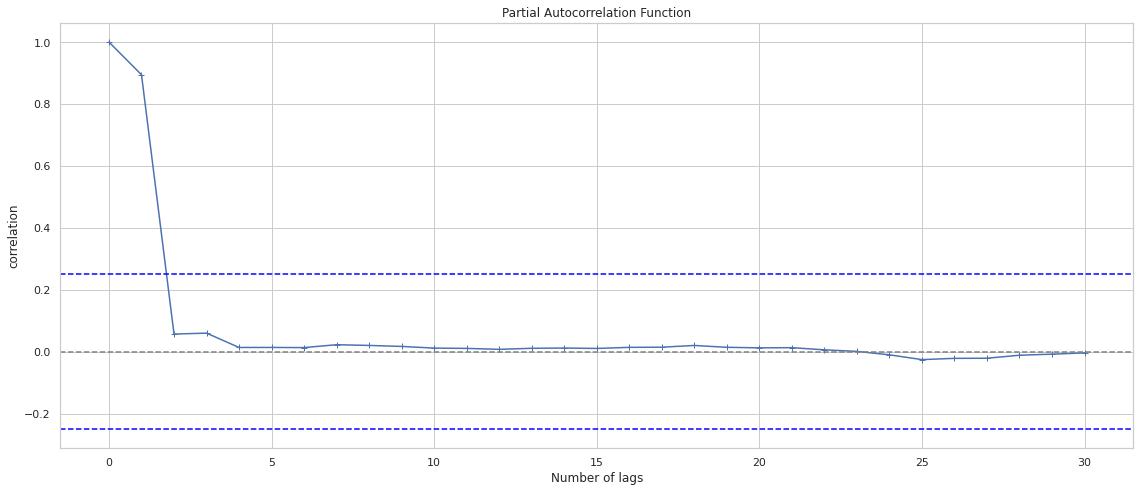

In [6]:
# The variable we choose to apply pacf

y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [7]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [8]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

# Linear regression

In [9]:
LinearRegression_PARAMS = {}

# train model
model = LinearRegression(**LinearRegression_PARAMS)
model.fit(train[features_columns], (train["PM2.5"]))

# Predictions and score on validation data
pred_val = model.predict(valid[features_columns])
pred_test = model.predict(test[features_columns])


# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=pred_val)
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=pred_val)
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=pred_val)

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=pred_test)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=pred_test)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=pred_test)

print(f"LinearRegression rmse valid: {sqrt(mse_score_valid)}")
print(f"LinearRegression rmae valid: {mae_score_valid}")
print(f"LinearRegression r2 valid : {r2_score_valid}")
print('\n')
print(f"LinearRegression rmse test: {sqrt(mse_score_test)}")
print(f"LinearRegression rmae test: {mae_score_test}")
print(f"LinearRegression r2 test: {r2_score_test}")

LinearRegression rmse valid: 13.168457410269673
LinearRegression rmae valid: 7.681518674506884
LinearRegression r2 valid : 0.9485998426884968


LinearRegression rmse test: 12.311002141839413
LinearRegression rmae test: 7.42726546991649
LinearRegression r2 test: 0.9555726471969599


# Cross validation Linear regression

In [10]:
N_SPLITS = 5
SEED = 42

In [11]:
train_data.shape[0] // (N_SPLITS + 1)

60243

In [12]:
np.ceil(train_data.shape[0]*0.1).astype(int)

36147

In [13]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

In [14]:
oof_lr = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_lr = np.zeros((test.shape[0]))
counter = 1


mse_scores_lr = []
mae_scores_lr = []
msle_scores_lr = []
r2_scores_lr = []
LinearRegression_PARAMS = {}


# Features to use for training and prediction
features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    x_train, y_train = train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"]
    x_val, y_val = train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"]
    x_test = test[features_columns]
    
    # Fit and train LinearRegression
    model = LinearRegression(**LinearRegression_PARAMS)
    model.fit(x_train, y_train) 

    # Predictions and score on validation data
    pred_val = model.predict(x_val)
    pred_test = model.predict(x_test)
    
    mse_score_valid = mse(y_true =train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    mae_score_valid = mae(y_true =train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true =train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} LinearRegression mse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} LinearRegression mae: {(mae_score_valid)}")
    print(f"Fold {counter} LinearRegression r2: {r2_score_valid}")
    print('\n')
    mse_scores_lr.append(sqrt(mse_score_valid))
    mae_scores_lr.append(mae_score_valid)
    r2_scores_lr.append(r2_score_valid)
    
    oof_lr[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_lr += pred_test / N_SPLITS
    counter += 1

    # CV score
    mse_score_cv = mse(y_true=oof_target, y_pred=oof_lr)
    mae_score_cv = mae(y_true=oof_target, y_pred=oof_lr)
    r2_score_cv = r2(y_true=oof_target, y_pred=oof_lr)

    # Inference score
    mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_lr)
    mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_lr)
    r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_lr)

print(f"LinearRegression rmse cv: {np.array(mse_scores_lr).mean()}")
print(f"LinearRegression rmae cv: {np.array(mae_scores_lr).mean()}")
print(f"LinearRegression r2 cv: {np.array(r2_scores_lr).mean()}")
print('\n')

print(f"LinearRegression rmse test: {sqrt(mse_score_test)}")
print(f"LinearRegression mae test: {(mae_score_test)}")
print(f"LinearRegression r2 test: {r2_score_test}")

CV 1/5




Fold 1 LinearRegression mse: 13.104958814229203
Fold 1 LinearRegression mae: 8.034918814962092
Fold 1 LinearRegression r2: 0.950349994573759


CV 2/5




Fold 2 LinearRegression mse: 12.82100553057121
Fold 2 LinearRegression mae: 7.700033802433699
Fold 2 LinearRegression r2: 0.9495525956162642


CV 3/5




Fold 3 LinearRegression mse: 12.078162354671028
Fold 3 LinearRegression mae: 6.8819169256451715
Fold 3 LinearRegression r2: 0.9504177496461637


CV 4/5




Fold 4 LinearRegression mse: 13.2383602815855
Fold 4 LinearRegression mae: 7.7865594200120976
Fold 4 LinearRegression r2: 0.9476979862411212


CV 5/5




Fold 5 LinearRegression mse: 13.24686211793482
Fold 5 LinearRegression mae: 7.789874596604675
Fold 5 LinearRegression r2: 0.9479853925438321


LinearRegression rmse cv: 12.897869819798354
LinearRegression rmae cv: 7.638660711931547
LinearRegression r2 cv: 0.949200743724228


LinearRegression rmse test: 12.296977424678687
LinearRegression mae test: 7.41143364758988
Line

# Lasso

In [15]:
Lasso_PARAMS = {"alpha" : 1.3, "max_iter":3000}
       

model_lasso = Lasso(**Lasso_PARAMS)
model_lasso.fit(train[features_columns], train["PM2.5"])

# Predictions and score on validation data
pred_val = model_lasso.predict(valid[features_columns])
pred_test = model_lasso.predict(test[features_columns])

# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=(pred_val))
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=(pred_val))
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=(pred_val))

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=(pred_test))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=(pred_test))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=(pred_test))

print("\n")

print(f"Lasso rmse valid: {sqrt(mse_score_valid)}")
print(f"Lasso mae valid: {mae_score_valid}")
print(f"Lasso r2 valid : {r2_score_valid}")
print('\n')
print(f"Lasso rmse test: {sqrt(mse_score_test)}")
print(f"Lasso mae test: {mae_score_test}")
print(f"Lasso r2 test: {r2_score_test}")



Lasso rmse valid: 13.253383945193246
Lasso mae valid: 7.6494927440459906
Lasso r2 valid : 0.9479347209739797


Lasso rmse test: 12.462314386194166
Lasso mae test: 7.467536380531984
Lasso r2 test: 0.954473839108638


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.801e+06, tolerance: 1.083e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


# Cross validation Lasso

In [16]:
# Place holders for predictions
oof_lasso = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_lasso = np.zeros((test.shape[0]))
counter = 1

# Placer holders for calculating scores
mse_scores_lasso = []
mae_scores_lasso = []
msle_scores_lasso = []
r2_scores_lasso = []




# Iterate over the whole folds
for trn_idx, vld_idx in tsp.split(train_data):
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    x_train, y_train = train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"]
    x_val, y_val = train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"]
    d_test = test[features_columns].astype("float")
    Lasso_PARAMS = {"alpha" : 1.3, "max_iter": 3000}
    
    # Fit and train Lasso
    model = Lasso(**Lasso_PARAMS)
    model.fit(x_train, y_train) 
    

    # Predictions and score on validation data
    pred_val = model.predict(x_val)
    pred_test = model.predict(d_test)
    
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} Lasso rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Lasso mae: {(mae_score_valid)}")
    print(f"Fold {counter} Lasso r2: {r2_score_valid}")
    print('\n')
    
    mse_scores_lasso.append(sqrt(mse_score_valid))
    mae_scores_lasso.append(mae_score_valid)
    r2_scores_lasso.append(r2_score_valid)
    
    oof_lasso[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_lasso += pred_test / N_SPLITS
    counter += 1
    
    
    
    
    
    # Inference score
    mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_lasso)
    mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_lasso)
    r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_lasso)

print(f"Lasso rmse cv: {np.array(mse_scores_lasso).mean()}")
print(f"Lasso rmae cv: {np.array(mae_scores_lasso).mean()}")
print(f"Lasso r2 cv: {np.array(r2_scores_lasso).mean()}")

print('\n')

print(f"Lasso rmse test: {sqrt(mse_score_test)}")
print(f"Lasso rmae test: {mae_score_test}")
print(f"Lasso r2 test: {r2_score_test}")

CV 1/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.671e+06, tolerance: 6.080e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive




Fold 1 Lasso rmse: 13.249568758321551
Fold 1 Lasso mae: 8.083717866741457
Fold 1 Lasso r2: 0.949248198112365


CV 2/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.754e+06, tolerance: 7.331e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive




Fold 2 Lasso rmse: 12.905933824702148
Fold 2 Lasso mae: 7.686043475684
Fold 2 Lasso r2: 0.9488820394284001


CV 3/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.777e+06, tolerance: 8.512e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive




Fold 3 Lasso rmse: 12.197654384254077
Fold 3 Lasso mae: 6.906353271486947
Fold 3 Lasso r2: 0.94943183959155


CV 4/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.700e+06, tolerance: 9.613e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive




Fold 4 Lasso rmse: 13.37070974349117
Fold 4 Lasso mae: 7.82783173562009
Fold 4 Lasso r2: 0.9466469882291928


CV 5/5




Fold 5 Lasso rmse: 13.277100511253012
Fold 5 Lasso mae: 7.668902187783998
Fold 5 Lasso r2: 0.9477476557439208


Lasso rmse cv: 13.000193444404392
Lasso rmae cv: 7.634569707463298
Lasso r2 cv: 0.9483913442210857


Lasso rmse test: 12.447836107387923
Lasso rmae test: 7.458762551633041
Lasso r2 test: 0.9545795590490673


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.801e+06, tolerance: 1.083e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


# Ridge

In [17]:
Ridge_PARAMS = {"alpha" : 1.3, "max_iter":3000}

model = Ridge(**Ridge_PARAMS)
model.fit(train[features_columns], (train["PM2.5"]))

# Predictions and score on validation data
pred_val = model.predict(valid[features_columns])
pred_test = model.predict(test[features_columns])


# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=(pred_val))
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=(pred_val))
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=(pred_val))

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=(pred_test))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=(pred_test))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=(pred_test))

print("\n")

print(f"Ridge rmse valid: {sqrt(mse_score_valid)}")
print(f"Ridge mae valid: {mae_score_valid}")
print(f"Ridge r2 valid : {r2_score_valid *100}")
print('\n')

print(f"Ridge rmse test: {sqrt(mse_score_test)}")
print(f"Ridge mae test: {mae_score_test}")
print(f"Ridge r2 test: {r2_score_test*100}")





Ridge rmse valid: 13.168450551966831
Ridge mae valid: 7.6815151132436705
Ridge r2 valid : 94.85998962282156


Ridge rmse test: 12.311004209009656
Ridge mae test: 7.427266841885218
Ridge r2 test: 95.55726322771496


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.07687e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


# Cross Validation Ridge

In [18]:
# Place holders for predictions
oof_ridge = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_ridge = np.zeros((test.shape[0]))
counter = 1

# Placer holders for calculating scores
mse_scores_ridge = []
mae_scores_ridge = []
msle_scores_ridge = []
r2_scores_ridge = []



# Iterate over the whole folds
for trn_idx, vld_idx in tsp.split(train_data):
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    
    x_train, y_train = train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"]
    x_val, y_val = train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"]
    d_test = test[features_columns].astype("float")
    
    
    Ridge_PARAMS = {"alpha" : 0.1}  
    # Fit and train ridge
    model = Ridge(**Ridge_PARAMS)
    model.fit(x_train, y_train) 

    # Predictions and score on validation data
    pred_val = model.predict(x_val)
    pred_test = model.predict(d_test)
    
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} ridge rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} ridge r2: {r2_score_valid}")
    print('\n')
    mse_scores_ridge.append(sqrt(mse_score_valid))
    r2_scores_ridge.append(r2_score_valid)
    oof_ridge[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_ridge += pred_test / N_SPLITS
    counter += 1
    
    
    
    
    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_ridge)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_ridge)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_ridge)

print(f"ridge rmse cv: {np.array(mse_scores_ridge).mean()}")
print(f"ridge rmae cv: {np.array(mae_scores_ridge).mean()}")
print(f"ridge r2 cv: {np.array(r2_scores_ridge).mean()}")

print('\n')

print(f"ridge rmse test: {sqrt(mse_score_test)}")
print(f"ridge rmae test: {mae_score_test}")
print(f"ridge r2 test: {r2_score_test}")

CV 1/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.69912e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T




Fold 1 ridge rmse: 13.104958646236675
Fold 1 ridge r2: 0.9503499958466862


CV 2/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75948e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T




Fold 2 ridge rmse: 12.821004834925814
Fold 2 ridge r2: 0.9495526010906403


CV 3/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.74954e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T




Fold 3 ridge rmse: 12.078161885884938
Fold 3 ridge r2: 0.9504177534950056


CV 4/5




/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.17978e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T




Fold 4 ridge rmse: 13.23836042318564
Fold 4 ridge r2: 0.9476979851222557


CV 5/5




Fold 5 ridge rmse: 13.246861598945861
Fold 5 ridge r2: 0.9479853966195152


ridge rmse cv: 12.897869477835787
ridge rmae cv: nan
ridge r2 cv: 0.9492007464348206


ridge rmse test: 12.296977838123215
ridge rmae test: 7.411433983635799
ridge r2 test: 0.9556738100097353


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.24581e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# SVR

In [19]:
%%time
SVR_PARAMS = {  "kernel" : "rbf",
                "C": 0.5,
                "verbose" : True,
                "max_iter" : 5000
             }

model = SVR(**SVR_PARAMS)
model.fit(train[features_columns], train["PM2.5"])

#Predictions and score on validation data
pred_val = model.predict(valid[features_columns])
pred_test = model.predict(test[features_columns])

mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=pred_val)
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=pred_val)
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=pred_val)
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=pred_val)

mse_score_test = mse(y_true=test["PM2.5"], y_pred=pred_test)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=pred_test)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=pred_test)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=pred_test)
print("\n")
print(f"SVR rmse valid: {sqrt(mse_score_valid)}")
print(f"SVR mae valid: {mae_score_valid}")
print(f"SVR rmsle valid: {sqrt(msle_score_valid)}")
print(f"SVR r2 valid{r2_score_valid*100}")
print('\n')

print(f"SVR rmse test: {sqrt(mse_score_test)}")
print(f"SVR mae test:  {mae_score_test}")
print(f"SVR rmsle test: {sqrt(msle_score_test)}")
print(f"SVR r2 test: {r2_score_test*100}")


[D] [21:06:40.735921] ../src/svm/workingset.cuh:122 Creating working set with 1024 elements
[D] [21:06:40.741531] ../src_prims/cache/cache.cuh:162 Creating cache with size=1024.000000 MiB, to store 384 vectors, in 12 sets with associativity=32
[D] [21:06:40.741933] ../src/svm/kernelcache.cuh:131 Allocating kernel tile, size: 2541 MiB
[D] [21:06:40.744761] ../src/svm/kernelcache.cuh:136 Allocating x_ws, size: 55 KiB
[D] [21:07:05.386018] ../src/svm/smosolver.cuh:188 SMO iteration 500, diff 54.824798
[D] [21:07:13.546021] ../src/svm/smosolver.cuh:191 SMO solver finished after 659 outer iterations, total inner iterations, and diff 0.000965


SVR rmse valid: 57.570866082520126
SVR mae valid: 44.083170644542975
SVR rmsle valid: 0.9847455607863372
SVR r2 valid1.7573277315457103


SVR rmse test: 57.66594123381334
SVR mae test:  43.97126418675923
SVR rmsle test: 1.0087015805162227
SVR r2 test: 2.522946500968559
CPU times: user 38.1 s, sys: 1.19 s, total: 39.3 s
Wall time: 42.2 s


# Cross validation SVR

In [20]:
# Place holders for predictions
oof_svr = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_svr = np.zeros((test.shape[0]))
counter = 1

# Placer holders for calculating scores
mse_scores_svr = []
mae_scores_svr= []
msle_scores_svr = []
r2_scores_svr = []


# Iterate over the whole folds
for trn_idx, vld_idx in tsp.split(train_data):
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    
    x_train, y_train = train_data.iloc[trn_idx][features_columns], train_data.iloc[trn_idx]["PM2.5"]
    x_val, y_val = train_data.iloc[vld_idx][features_columns], train_data.iloc[vld_idx]["PM2.5"]
    x_test = test[features_columns].astype("float")
    
    
    SVR_PARAMS = {  "kernel" : "rbf",
                "C": 0.5,
                "verbose" : True,
                "max_iter" : 5000
             }
    
    # Fit and train ridge
    model = SVR(**SVR_PARAMS)
    model.fit(x_train, y_train) 

    # Predictions and score on validation data
    pred_val = model.predict(x_val)
    pred_test = model.predict(x_test)
    
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=pred_val)
    print('\n')
    print(f"Fold {counter} ridge rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} ridge r2: {r2_score_valid}")
    print('\n')
    mse_scores_svr.append(sqrt(mse_score_valid))
    r2_scores_svr.append(r2_score_valid)
    oof_svr[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_svr += pred_test / N_SPLITS
    counter += 1
    
    
    
    
    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=predictions_svr)
mae_score_test = mae(y_true=test["PM2.5"], y_pred=predictions_svr)
msle_score_test = msle(y_true=test["PM2.5"], y_pred=predictions_svr)
r2_score_test = r2(y_true=test["PM2.5"], y_pred=predictions_svr)

print(f"ridge rmse cv: {np.array(mse_scores_svr).mean()}")
print(f"ridge rmae cv: {np.array(mae_scores_svr).mean()}")
print(f"ridge rmsle cv: {np.array(msle_scores_svr).mean()}")
print(f"ridge r2 cv: {np.array(r2_scores_svr).mean()}")

print('\n')

print(f"ridge rmse test: {sqrt(mse_score_test)}")
print(f"ridge rmae test: {mae_score_test}")
print(f"ridge rmsle test: {sqrt(msle_score_test)}")
print(f"ridge r2 test: {r2_score_test}")

CV 1/5


[D] [21:07:17.150414] cuml/common/logger.cpp:3088 Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
[D] [21:07:17.174405] ../src/svm/workingset.cuh:122 Creating working set with 1024 elements
[D] [21:07:17.176955] ../src_prims/cache/cache.cuh:162 Creating cache with size=1024.000000 MiB, to store 736 vectors, in 23 sets with associativity=32
[D] [21:07:17.177003] ../src/svm/kernelcache.cuh:131 Allocating kernel tile, size: 1411 MiB
[D] [21:07:17.178835] ../src/svm/kernelcache.cuh:136 Allocating x_ws, size: 55 KiB
[D] [21:07:28.596867] ../src/svm/smosolver.cuh:191 SMO solver finished after 367 outer iterations, total inner iterations, and diff 0.000976


Fold 1 ridge rmse: 55.78788090323465
Fold 1 ridge r2: 0.10023787114898053


CV 2/5


[D] [21:07:30.416035] cuml/common/logger.cpp:3088 Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utiliza

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice.
